In [1]:
import numpy as np
import pandas as pd
import polars as pl
import marshal, json
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib.patches as patches
from matplotlib import cm
import matplotlib
import json, math
from scipy.optimize import curve_fit
from operator import sub
import scipy.stats
from IPython.display import set_matplotlib_formats
from IPython.display import Image
import matplotlib_inline.backend_inline


#matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({
    'font.family': 'serif',
    "font.serif": 'Times',
    'font.size': 12,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.latex.preamble': r'\usepackage{amsmath}'
})

v = 48
n = 100
num_runs = 20

In [2]:
def get_rdf_loss_rate(i, q = 0):
    loss_rates = []
    for r in range(num_runs):
        try:
            df = pl.read_csv(f'../res/v{v}/loss_rate_rdf_n{n}_i{i}_q{q}_r{r}.csv')
            loss_rates.append(1-df['reception_rates'].mean())
        except:
            pass
    return np.mean(loss_rates) if len(loss_rates) > 0 else 0

def get_rdf_performance(i, q = 0):
    p_ex = []
    p_d = []
    for r in range(num_runs):
        try:
            df = pl.read_csv(f'../res/v{v}/kpi_rdf_n{n}_i{i}_q{q}_r{r}.csv')
            p_ex.append(df['pe500'])
            p_d.append(df['pd'])
        except:
            pass
    return (np.mean(p_ex), np.mean(p_d))


In [3]:
def get_sf_loss_rate(i, p = 100):
    loss_rates = []
    for r in range(num_runs):
        try:
            df = pl.read_csv(f'../res/v{v}/loss_rate_sf_n{n}_i{i}_p{p}_r{r}.csv')
            loss_rates.append(1-df['reception_rates'].mean())
        except:
            pass
    return np.mean(loss_rates) if len(loss_rates) > 0 else 0

def get_sf_performance(i, p = 100):
    p_ex = []
    p_d = []
    for r in range(num_runs):
        try:
            df = pl.read_csv(f'../res/v{v}/kpi_sf_n{n}_i{i}_p{p}_r{r}.csv')
            p_ex.append(df['pe500'])
            p_d.append(df['pd'])
        except:
            pass
    return (np.mean(p_ex), np.mean(p_d))

In [4]:
p_d_target = 0.99
p_ex_target = 0.01

send_intervals = np.array([60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420])
loss_rates_rdf = []
loss_rates_pf = []
loss_rates_sf = []
loss_rates_cbf = []

p_ex_rdf = []
p_d_rdf = []
p_ex_cbf = []
p_d_cbf = []
p_ex_sf = []
p_d_sf = []
p_ex_pf = []
p_d_pf = []

for i in send_intervals:
    loss = get_rdf_loss_rate(i, 200)
    loss_rates_rdf.append(loss)
    (p_ex, p_d) = get_rdf_performance(i, 200)
    p_ex_rdf.append(p_ex)
    p_d_rdf.append(p_d)

    loss = get_sf_loss_rate(i, 50)
    loss_rates_sf.append(loss)
    (p_ex, p_d) = get_sf_performance(i, 50)
    p_ex_sf.append(p_ex)
    p_d_sf.append(p_d)

    loss = get_rdf_loss_rate(i)
    loss_rates_cbf.append(loss)
    (p_ex, p_d) = get_rdf_performance(i)
    p_ex_cbf.append(p_ex)
    p_d_cbf.append(p_d)

    loss = get_sf_loss_rate(i)
    loss_rates_pf.append(loss)
    (p_ex, p_d) = get_sf_performance(i)
    p_ex_pf.append(p_ex)
    p_d_pf.append(p_d)

loss_rates_rdf = np.array(loss_rates_rdf)
loss_rates_cbf = np.array(loss_rates_cbf)
loss_rates_pf = np.array(loss_rates_pf)
loss_rates_sf = np.array(loss_rates_sf)

In [5]:
print(p_ex_rdf)
print(p_d_rdf)

[0.00235389, 0.002874629, 0.003847673499999999, 0.006343112000000001, 0.0057266439999999995, 0.008305258000000001, 0.008160052142857145, 0.014264978571428572, 0.013183021428571428, 0.012313407142857145, 0.012449878571428572, 0.03989391428571428, 0.037777007142857144]
[0.99862125, 0.9997828500000001, 0.9998585999999999, 0.9996667, 0.9995959999999998, 0.999394, 0.9993723571428571, 0.9988095714285714, 0.9988529285714286, 0.9982179999999999, 0.9982541428571429, 0.9976047142857142, 0.9965440714285716]


In [6]:
def model(x, a, b, c):
    return np.exp(-a * np.power(x, b))

RDF [2.33121226 0.35682688 1.        ]
CBF [1.55736917 0.35002777 1.        ]
SF [1.53371305 0.27495231 1.        ]
PF [0.85581321 0.20066486 1.        ]


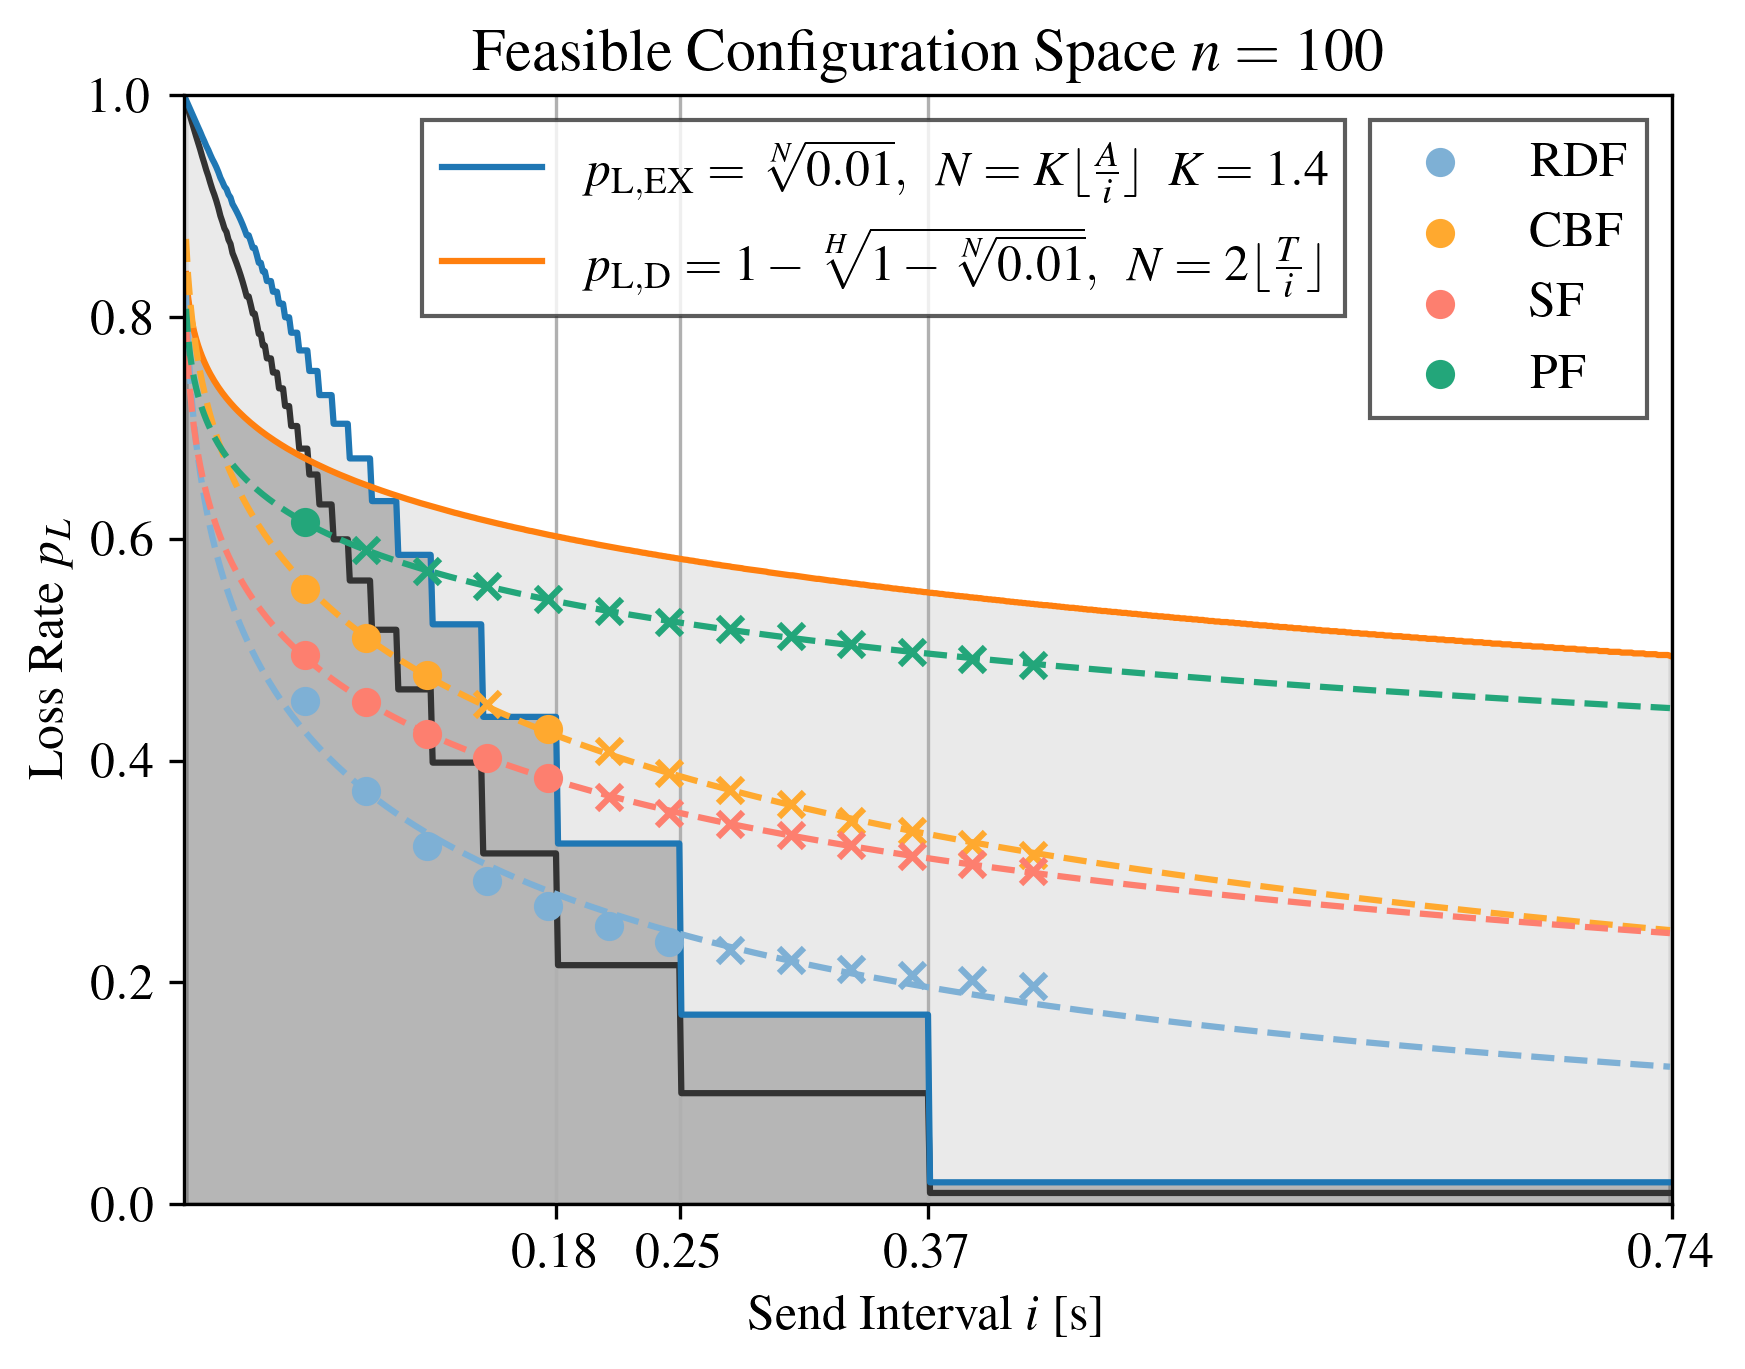

In [54]:
rdf_color = '#7eb0d5'
sf_color = '#fd7f6f'
pf_color = '#23a67a'
cbf_color = '#ffa92f'

alpha = 0.5


aoi_target = 0.736
L = math.sqrt(n/12)
T = L*1000 / 33.3
H = L / 0.5
i = np.arange(0.001, aoi_target, 0.001)
idx = [x for x,_ in enumerate(i)]

num_attempts_pex = np.floor(aoi_target / i)
per_pex_old = np.power(0.01, 1/(num_attempts_pex))
per_pex =  (alpha -1) / (2 * alpha) + np.sqrt(np.power((1-alpha)/(2 * alpha),2) + np.power(0.01, 1/(num_attempts_pex)) / alpha)

num_attempts_pd = 2*np.floor(T / i)

per_pd = 1- np.power(1-np.power(0.01, 1/num_attempts_pd),1/H)

fig, ax = plt.subplots()

ax.plot(i, per_pex_old, color="#333")
lex, = ax.plot(i, per_pex)
ax.fill_between(i, per_pex, i * 0, color='#333', alpha=0.1)

ld, = ax.plot(i, per_pd)
ax.fill_between(i, per_pd, i * 0, color='#333', alpha=0.1)

ax.fill_between(i, np.minimum(per_pd, per_pex), i * 0, color='#333', alpha=0.2)

x_ticks = aoi_target / np.arange(1,5,1)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'{x:.2f}' for x in x_ticks])

# ax.text(aoi_target /1.97 , 0.3, )
# ax.text(aoi_target /1.97 , 0.2, )

leg1 = ax.legend(
    [lex, ld], 
    [u'$p_\\mathrm{L,EX} = \\sqrt[N]{0.01} ,\;\; N = K\\lfloor{\\frac{A}{i}} \\rfloor\;\; K = 1.4$', u'$p_\\mathrm{L,D} = 1 - \\sqrt[H]{1-\\sqrt[N]{0.01}} ,\;\; N = 2\\lfloor{\\frac{T}{i}} \\rfloor$'], 
    bbox_to_anchor=(0.47, 1),
    loc=9,
    fancybox = False
    )
leg1.get_frame().set_edgecolor('#333')
plt.gca().add_artist(leg1)

si = send_intervals / 1000

working_configs = np.array(p_ex_rdf) <= p_ex_target#np.logical_and(np.array(p_ex_rdf) <= p_ex_target, np.array(p_d_rdf) >= p_d_target)
ax.scatter(si[working_configs], loss_rates_rdf[working_configs], color=rdf_color, zorder=100, label="RDF")
ax.scatter(si[np.logical_not(working_configs)], loss_rates_rdf[np.logical_not(working_configs)], color=rdf_color, zorder=100, marker="x")
param, _ = curve_fit(model, si, loss_rates_rdf)
ax.plot(i, model(i, param[0], param[1], param[2]),'--' ,color=rdf_color)
print('RDF', param)

working_configs = np.array(p_ex_cbf) <= p_ex_target#np.logical_and(np.array(p_ex_cbf) <= p_ex_target, np.array(p_d_cbf) >= p_d_target)
ax.scatter(si[working_configs], loss_rates_cbf[working_configs], color=cbf_color, zorder=100, label="CBF")
ax.scatter(si[np.logical_not(working_configs)], loss_rates_cbf[np.logical_not(working_configs)], color=cbf_color, zorder=100, marker="x" )
param, _ = curve_fit(model, si, loss_rates_cbf)
ax.plot(i, model(i, param[0], param[1], param[2]),'--' ,color=cbf_color)
print('CBF', param)

working_configs = np.array(p_ex_sf) <= p_ex_target#np.logical_and(np.array(p_ex_sf) <= p_ex_target, np.array(p_d_sf) >= p_d_target)
ax.scatter(si[working_configs], loss_rates_sf[working_configs], color=sf_color ,zorder=100, label="SF")
ax.scatter(si[np.logical_not(working_configs)], loss_rates_sf[np.logical_not(working_configs)], color=sf_color ,zorder=100, marker="x")
param, _ = curve_fit(model, si, loss_rates_sf)
ax.plot(i, model(i, param[0], param[1], param[2]),'--' ,color=sf_color)
print('SF', param)

working_configs = np.array(p_ex_pf) <= p_ex_target#np.logical_and(np.array(p_ex_pf) <= p_ex_target, np.array(p_d_pf) >= p_d_target)
ax.scatter(si[working_configs], loss_rates_pf[working_configs], color=pf_color, zorder=100, label="PF")
ax.scatter(si[np.logical_not(working_configs)], loss_rates_pf[np.logical_not(working_configs)], color=pf_color, zorder=100, marker="x")
param, _ = curve_fit(model, si, loss_rates_pf)
ax.plot(i, model(i, param[0], param[1], param[2]),'--' ,color=pf_color)
print('PF', param)


ax.grid(axis='x')

plt.title(f'Feasible Configuration Space $n={n}$')

ax.set_ylabel('Loss Rate $p_L$')
ax.set_xlabel('Send Interval $i$ [s]')
leg = ax.legend(fancybox=False, bbox_to_anchor=(0.89, 1), loc=9)
leg.get_frame().set_edgecolor('#333')
ax.set_ylim([0,1])
ax.set_xlim([0,aoi_target])
plt.show()

fig.savefig(f"../figures/feasible_region_n{n}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../figures/feasible_region_n{n}.png", dpi=500, bbox_inches='tight', pad_inches=0.01)

In [8]:
print(p_d_sf)

[0.9678837500000002, 0.9901666500000001, 0.9961464999999998, 0.9974546999999999, 0.9988282999999999, 0.9993334, 0.9992712857142857, 0.9992425, 0.9992618461538462, 0.9991686153846154, 0.9994172307692307, 0.9994017692307692, 0.9991453076923078]


In [13]:
np.power(0.01, 1/(num_attempts_pex))

array([0.99376251, 0.98756393, 0.98137894, 0.97528251, 0.96915794,
       0.96295625, 0.95708912, 0.95117597, 0.94473203, 0.93886411,
       0.93260335, 0.92728474, 0.92105532, 0.91524731, 0.91029818,
       0.90473572, 0.89843854, 0.89125094, 0.88586679, 0.87992254,
       0.87671239, 0.869749  , 0.86596432, 0.8576959 , 0.85316785,
       0.8483429 , 0.84319093, 0.83767764, 0.83176377, 0.82540419,
       0.81854673, 0.81854673, 0.81113083, 0.80308572, 0.80308572,
       0.79432823, 0.78475997, 0.78475997, 0.77426368, 0.77426368,
       0.76269859, 0.76269859, 0.76269859, 0.74989421, 0.74989421,
       0.74989421, 0.73564225, 0.73564225, 0.73564225, 0.71968567,
       0.71968567, 0.71968567, 0.70170383, 0.70170383, 0.70170383,
       0.70170383, 0.68129207, 0.68129207, 0.68129207, 0.68129207,
       0.68129207, 0.65793322, 0.65793322, 0.65793322, 0.65793322,
       0.65793322, 0.63095734, 0.63095734, 0.63095734, 0.63095734,
       0.63095734, 0.63095734, 0.63095734, 0.59948425, 0.59948

In [43]:
# fig, ax = plt.subplots()
# p_L = np.arange(0, 1, 0.01)

# N = 0

# ax.plot(p_L, np.power(p_L, 2))
# ax.plot(p_L, p_L ** 2 + p_L ** (N+1) * (1-p_L))


# plt.show()

[0.99553896]
[0.99109443]
[0.98664831]
[0.98225468]
[0.97782952]
[0.97333706]
[0.96907615]
[0.9647711]
[0.96006728]
[0.95577264]
[0.95117852]
[0.947266]
[0.94267194]
[0.93837741]
[0.93470931]
[0.93057708]
[0.92588673]
[0.92051709]
[0.91648342]
[0.91201876]
[0.90960265]
[0.90434957]
[0.90148745]
[0.89521723]
[0.89177332]
[0.88809562]
[0.88415952]
[0.87993684]
[0.87539516]
[0.87049698]
[0.8651987]
[0.8651987]
[0.85944931]
[0.85318879]
[0.85318879]
[0.84634601]
[0.83883603]
[0.83883603]
[0.83055661]
[0.83055661]
[0.82138361]
[0.82138361]
[0.82138361]
[0.8111648]
[0.8111648]
[0.8111648]
[0.79971147]
[0.79971147]
[0.79971147]
[0.78678697]
[0.78678697]
[0.78678697]
[0.77209053]
[0.77209053]
[0.77209053]
[0.77209053]
[0.75523426]
[0.75523426]
[0.75523426]
[0.75523426]
[0.75523426]
[0.73570962]
[0.73570962]
[0.73570962]
[0.73570962]
[0.73570962]
[0.71283743]
[0.71283743]
[0.71283743]
[0.71283743]
[0.71283743]
[0.71283743]
[0.71283743]
[0.68569169]
[0.68569169]
[0.68569169]
[0.68569169]
[0.6856

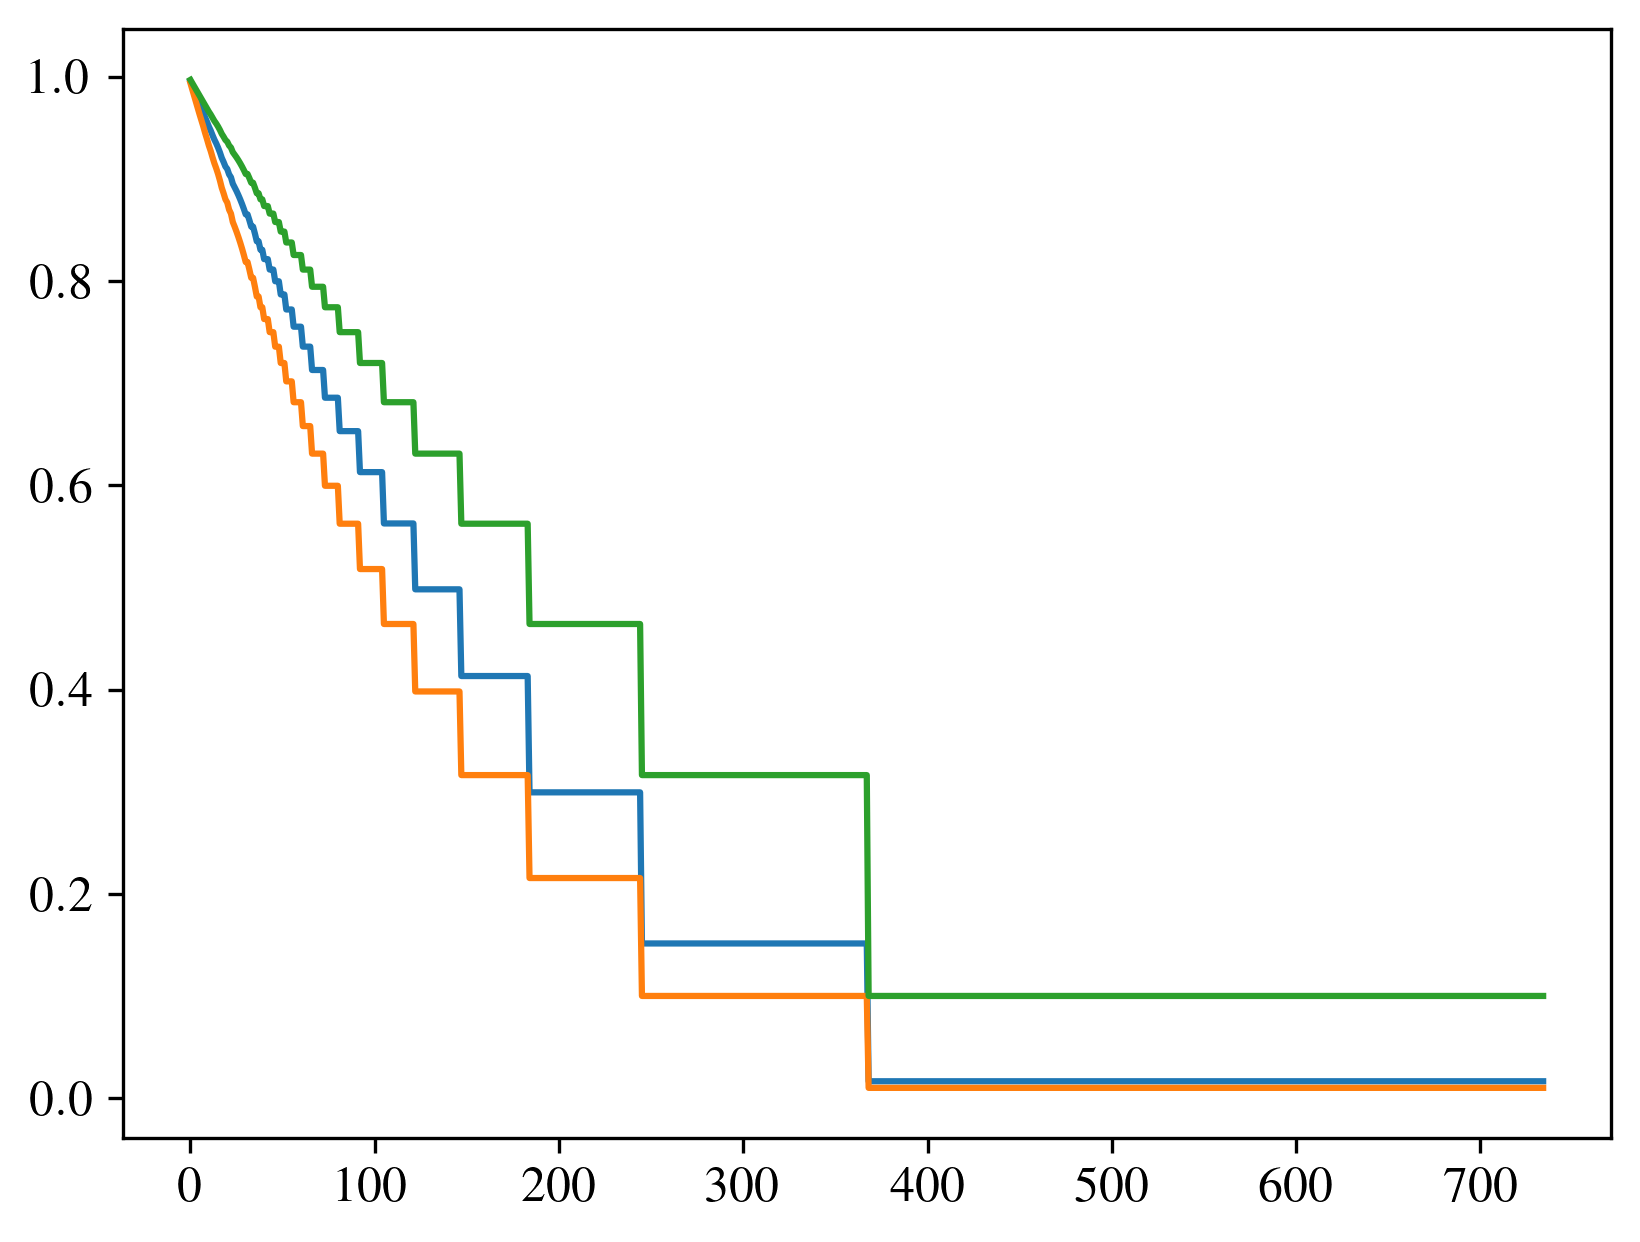

In [45]:
pers = []
alpha = 0.4
for u in range(len(per_pex_old)):
    r = np.polynomial.polynomial.polyroots([-per_pex_old[u], (1-alpha), alpha])
    r = r[~np.iscomplex(r)]
    r = r[r > 0]
    r = r[r < 1]
    pers.append(r[0])
    print(r)

fig, ax = plt.subplots()
ax.plot(pers)
ax.plot(per_pex_old)
ax.plot(per_pex)
plt.show()